In [175]:
import pandas as pd
import numpy as np
import json

import standings_api_calls

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px

In [ ]:
colors = json.load(open('data/teams.json'))

In [83]:
colors

[{'name': 'AFC Bournemouth',
  'league': 'epl',
  'colors': {'hex': ['E62333', '000000']}},
 {'name': 'Arsenal',
  'league': 'epl',
  'colors': {'hex': ['EF0107', '023474', '9C824A']}},
 {'name': 'Brighton & Hove Albion',
  'league': 'epl',
  'colors': {'hex': ['0055a9', 'F8BC1B']}},
 {'name': 'Burnley',
  'league': 'epl',
  'colors': {'hex': ['8CCCE5', '53162F', 'F9EC34']}},
 {'name': 'Chelsea',
  'league': 'epl',
  'colors': {'hex': ['034694', 'DBA111', 'ED1C24']}},
 {'name': 'Crystal Palace',
  'league': 'epl',
  'colors': {'hex': ['1B458F', 'C4122E', 'A7A5A6']}},
 {'name': 'Everton', 'league': 'epl', 'colors': {'hex': ['274488']}},
 {'name': 'Huddersfield Town', 'league': 'epl', 'colors': {'hex': ['0073d2']}},
 {'name': 'Leicester City',
  'league': 'epl',
  'colors': {'hex': ['FDBE11', '0053A0']}},
 {'name': 'Liverpool',
  'league': 'epl',
  'colors': {'hex': ['00A398', 'D00027', 'FEF667']}},
 {'name': 'Manchester City',
  'league': 'epl',
  'colors': {'hex': ['98c5e9', '00285e', 

In [4]:
standings = standings_api_calls.main(league='all', 
                                     csv=True,
                                     cached=True).reset_index(drop=True)

In [5]:
standings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5982 entries, 0 to 5981
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         5982 non-null   object 
 1   name         5982 non-null   object 
 2   percentage   5982 non-null   float64
 3   season_year  5982 non-null   int64  
 4   season       5982 non-null   object 
 5   league       5982 non-null   object 
 6   city_group   5982 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 327.3+ KB


In [6]:
standings.loc[:, 'season_order'] = np.NaN
standings.loc[standings['league'] == 'NHL', 'season_order'] = 0
standings.loc[standings['league'] == 'NBA', 'season_order'] = 1
standings.loc[standings['league'] == 'MLB', 'season_order'] = 2
standings.loc[standings['league'] == 'NFL', 'season_order'] = 3

standings.loc[:, 'chart_position'] = standings['season_year'] + standings['season_order']*.25
standings = standings.sort_values('chart_position').reset_index(drop=True)

In [7]:
standings['z_score'] = standings.groupby(['league', 'season_year'])['percentage'].transform(lambda x: (x - x.mean()) / x.std())

In [8]:
exclusions = standings.groupby(['city_group', 'season_year'])['name'].count().reset_index()
retain = exclusions.loc[exclusions['name'] > 1]

In [9]:
retain

,city_group,season_year,name
0,Atlanta,1969,2
1,Atlanta,1970,3
2,Atlanta,1971,3
3,Atlanta,1972,3
4,Atlanta,1973,4
...,...,...,...
2390,Washington,2020,4
2391,Washington,2021,4
2392,Washington,2022,4
2393,Washington,2023,4


In [10]:
standings = standings[
    (standings['city_group'].isin(retain['city_group'])) &
    (standings['season_year'].isin(retain['season_year']))
    ]

In [11]:
standings[standings['city_group'] == 'Dallas']

,city,name,percentage,season_year,season,league,city_group,season_order,chart_position,z_score
50,Dallas,Cowboys,0.821429,1969,1969,NFL,Dallas,3.0,1969.75,1.084539
118,Dallas,Cowboys,0.714286,1970,1970,NFL,Dallas,3.0,1970.75,1.138625
209,Dallas,Cowboys,0.785714,1971,1971,NFL,Dallas,3.0,1971.75,1.543333
242,Texas,Rangers,0.350649,1972,1972,MLB,Dallas,2.0,1972.50,-2.032395
272,Dallas,Cowboys,0.714286,1972,1972,NFL,Dallas,3.0,1972.75,0.900087
...,...,...,...,...,...,...,...,...,...,...
5856,Dallas,Cowboys,0.705882,2023,2023,NFL,Dallas,3.0,2023.75,1.273917
5889,Dallas,Stars,0.689024,2024,20232024,NHL,Dallas,0.0,2024.00,1.277562
5919,Dallas,Mavericks,0.610000,2024,2023-24,NBA,Dallas,1.0,2024.25,0.672576
5921,Texas,Rangers,0.481481,2024,2024,MLB,Dallas,2.0,2024.50,-0.240352


In [12]:
standings['rolling_mean'] = standings.sort_values(by=['season_year', 'season_order']).groupby('city_group')['z_score'].transform(
    lambda x: x.rolling(4, min_periods=1).mean()
)

In [13]:
standings.sort_values('rolling_mean', ascending=False)

,city,name,percentage,season_year,season,league,city_group,season_order,chart_position,z_score,rolling_mean
435,Miami,Dolphins,0.785714,1974,1974,NFL,South Florida,3.0,1974.75,1.516002,1.630843
49,Baltimore,Orioles,0.672840,1969,1969,MLB,Baltimore,2.0,1969.50,1.870111,1.576510
95,Baltimore,Orioles,0.666667,1970,1970,MLB,Baltimore,2.0,1970.50,2.140754,1.551729
361,Miami,Dolphins,0.857143,1973,1973,NFL,South Florida,3.0,1973.75,1.539849,1.536499
274,Miami,Dolphins,1.000000,1972,1972,NFL,South Florida,3.0,1972.75,2.117105,1.535382
...,...,...,...,...,...,...,...,...,...,...,...
5443,Detroit,Tigers,0.396552,2020,2020,MLB,Detroit,2.0,2020.50,-1.111539,-1.766773
744,New Jersey,Nets,0.293000,1978,1977-78,NBA,New Jersey,1.0,1978.25,-1.858510,-1.858510
610,Tampa Bay,Buccaneers,0.000000,1976,1976,NFL,Tampa Bay,3.0,1976.75,-1.918804,-1.918804
22,Phoenix,Suns,0.195000,1969,1968-69,NBA,Phoenix,1.0,1969.25,-2.005398,-2.005398


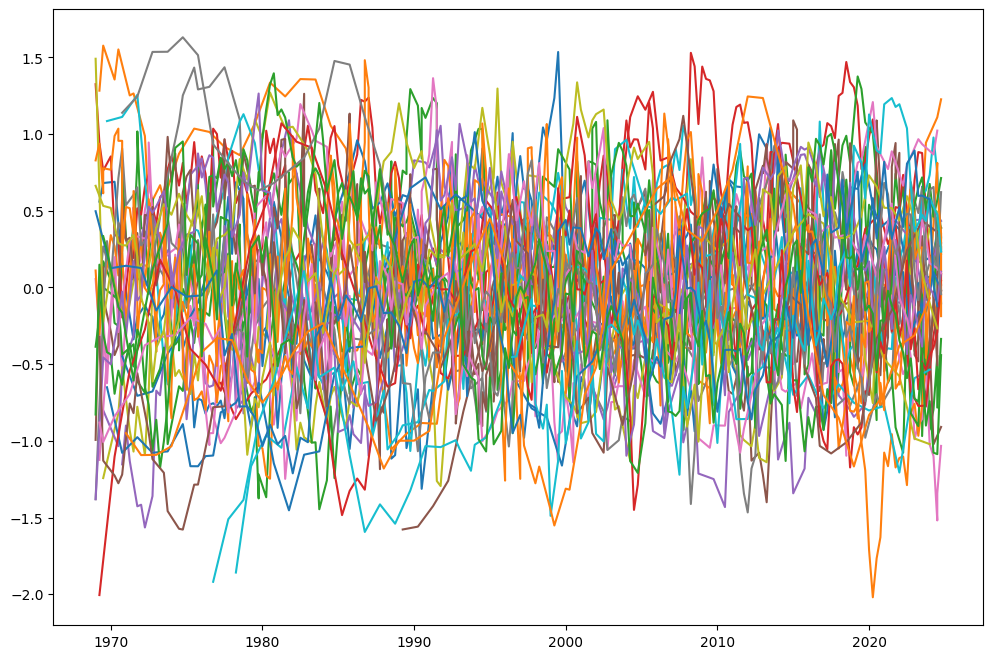

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

count = 0
for key, group in standings.groupby('city_group'):
    ax.plot(group['chart_position'], group['rolling_mean'], label=key)

In [15]:
grouped_standings = standings.groupby(['season_year', 'city_group'])['z_score'].agg(
    ['sum', 'mean', 'count']
    ).reset_index()

In [16]:
grouped_standings

,season_year,city_group,sum,mean,count
0,1969,Atlanta,1.361146,0.680573,2
1,1969,Baltimore,3.153021,1.576510,2
2,1969,Bay Area,0.683061,0.170765,4
3,1969,Boston,2.285657,0.761886,3
4,1969,Chicago,-2.440299,-0.488060,5
...,...,...,...,...,...
1792,2024,St. Louis,0.246539,0.123269,2
1793,2024,Tampa Bay,0.751348,0.250449,3
1794,2024,Toronto,-1.098853,-0.366284,3
1795,2024,Vancouver,1.050756,1.050756,1


In [17]:
grouped_standings[grouped_standings['count'] > 3].sort_values('mean', ascending=False)

,season_year,city_group,sum,mean,count
344,1980,Philadelphia,5.584138,1.396035,4
1569,2018,Boston,5.355384,1.338846,4
613,1989,Bay Area,5.172179,1.293045,4
1272,2009,Boston,5.115761,1.278940,4
518,1986,Boston,4.844292,1.211073,4
...,...,...,...,...,...
1610,2019,Detroit,-4.769161,-1.192290,4
1770,2024,Chicago,-6.313254,-1.262651,5
1129,2004,Phoenix,-5.146632,-1.286658,4
1352,2011,Minnesota,-5.372812,-1.343203,4


In [18]:
overall_standings = standings.groupby('city_group')['z_score'].agg(
    ['sum', 'mean', 'count']
    ).reset_index()

In [19]:
overall_standings.sort_values('mean')

,city_group,sum,mean,count
31,Vancouver,-22.436411,-0.380278,59
25,San Diego,-37.021481,-0.330549,112
29,Tampa Bay,-32.212448,-0.301051,107
5,Carolina,-23.962576,-0.266251,90
8,Cleveland,-38.457630,-0.234498,164
19,New Jersey,-16.418649,-0.216035,76
20,New Orleans,-17.929939,-0.216023,83
23,Phoenix,-23.727789,-0.161414,147
11,Detroit,-31.632266,-0.141849,223
14,Kansas City,-12.766754,-0.101323,126


In [20]:
fig = px.line(standings, 
              x = 'chart_position', 
              y = 'rolling_mean', 
              color = 'city', 
              line_group = 'city', 
              hover_name = 'city',
              template='plotly_dark')

In [21]:
fig.show()

In [272]:
standings['z_score'].min(), standings['z_score'].max()

(-3.2930937000916796, 2.7415989205701567)

In [369]:
def create_main_plot(fig, ax, city, year):
    df_city_year = grouped_standings[
        (grouped_standings['city_group'] == city) &
        (grouped_standings['season_year'] == year)
    ]

    sns.set_style("dark")
    sns.histplot(grouped_standings, x='sum', ax=ax, alpha=0.5, bins=30, color='blue')
    if not df_city_year.empty:
        ax.axvline(df_city_year['sum'].values[0], color='red', linestyle='--')
    ax.set_title(f'{city} in {year} vs All Other Cities and Years')
    ax.set_xlabel('Sum of Z-Scores')
    ax.set_ylabel('Number of Cities')
    ax.legend([f'{city} in {year}', 'All Cities'])

    ax.set_xlim(-7,7)  
    

In [370]:
def get_colors(team, league):
    team_colors = [c for c in colors if team in c['name'] and c['league'] == league.lower()]
    if len(team_colors) == 1 and team_colors[0]['league'] != 'nba':
        if len(team_colors[0]['colors']['hex']) > 1:
            team_color = '#' + team_colors[0]['colors']['hex'][0]
            gapcolor = '#' + team_colors[0]['colors']['hex'][1]
        else:
            team_color = '#' + team_colors[0]['colors']['hex'][0]
            gapcolor = 'gray'
    elif len(team_colors) == 1 and team_colors[0]['league'] == 'nba':
        if len(team_colors[0]['colors']['rgb']) > 1:
            team_color = [c for c in team_colors[0]['colors']['rgb'][0].split(' ')]
            team_color = tuple([int(c)/255 for c in team_color])
            gapcolor = [c for c in team_colors[0]['colors']['rgb'][1].split(' ')]
            gapcolor = tuple([int(c)/255 for c in gapcolor])
        else:
            team_color = [c for c in team_colors[0]['colors']['rgb'][0].split(' ')]
            team_color = tuple([int(c)/255 for c in team_color])
            gapcolor = 'gray'
    else:
        team_color = 'gray'   
        gapcolor = 'gray' 
    return team_color, gapcolor

def determine_limits(df, year):
    df_year = df[df['season_year'] == year]
    min_val = df_year['z_score'].min()
    max_val = df_year['z_score'].max()

    setter = max(abs(min_val), abs(max_val))
    if setter < 0:
        setter = setter * -1
    return setter

def create_subplots(fig, ax, grid_spec, year, df):

    xlim_setter = determine_limits(df, year)
     
    for ix, (team, league) in enumerate(zip(df['name'], df['league'])):
        row = (ix // 2) + 1
        col = ix % 2
        ax = fig.add_subplot(grid_spec[row, col])
        df_kde = standings[
            (standings['season_year'] == year) &
            (standings['league'] == league)
        ]

        team_color, gapcolor = get_colors(team, league)

        sns.set_style("dark")

        sns.histplot(df_kde, x='z_score', ax=ax, label=f'{league} {year}', alpha=0.25, bins=15, color='blue', kde=True)

        ax.axvline(df.iloc[ix]['z_score'], color=team_color, gapcolor=gapcolor, linestyle='--', label=team)
        ax.set_title(f'{team} {year}')
        ax.set_xlabel('Team Z-Score')
        ax.set_ylabel('Teams')
        ax.legend()
        ax.label_outer()

        ax.set_xlim(-xlim_setter-xlim_setter*.1, xlim_setter+xlim_setter*.1)


In [371]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

def plot_city_year(city, year):
    
    
    df_teams = standings[
        (standings['city_group'] == city) &
        (standings['season_year'] == year)
    ]
    
    num_teams = len(df_teams)
    n_rows = (num_teams + 1) // 2  # 2 plots per row

    # Create a grid with space for a large top plot + team plots below

    fig = plt.figure(figsize=(11, 4 + n_rows * 3))
    gs = gridspec.GridSpec(n_rows + 1, 2, height_ratios=[1.2] + [1]*n_rows)

    ax = fig.add_subplot(gs[0, :])
    # Top row: full-width city-level KDE plot
    create_main_plot(fig=fig, ax=ax, city=city, year=year)

    # Team-level KDEs

    create_subplots(
        fig=fig, ax=ax, grid_spec=gs, year=year, df=df_teams
    )

    fig.suptitle(f'{city} {year}: Normalized Results Across Teams', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


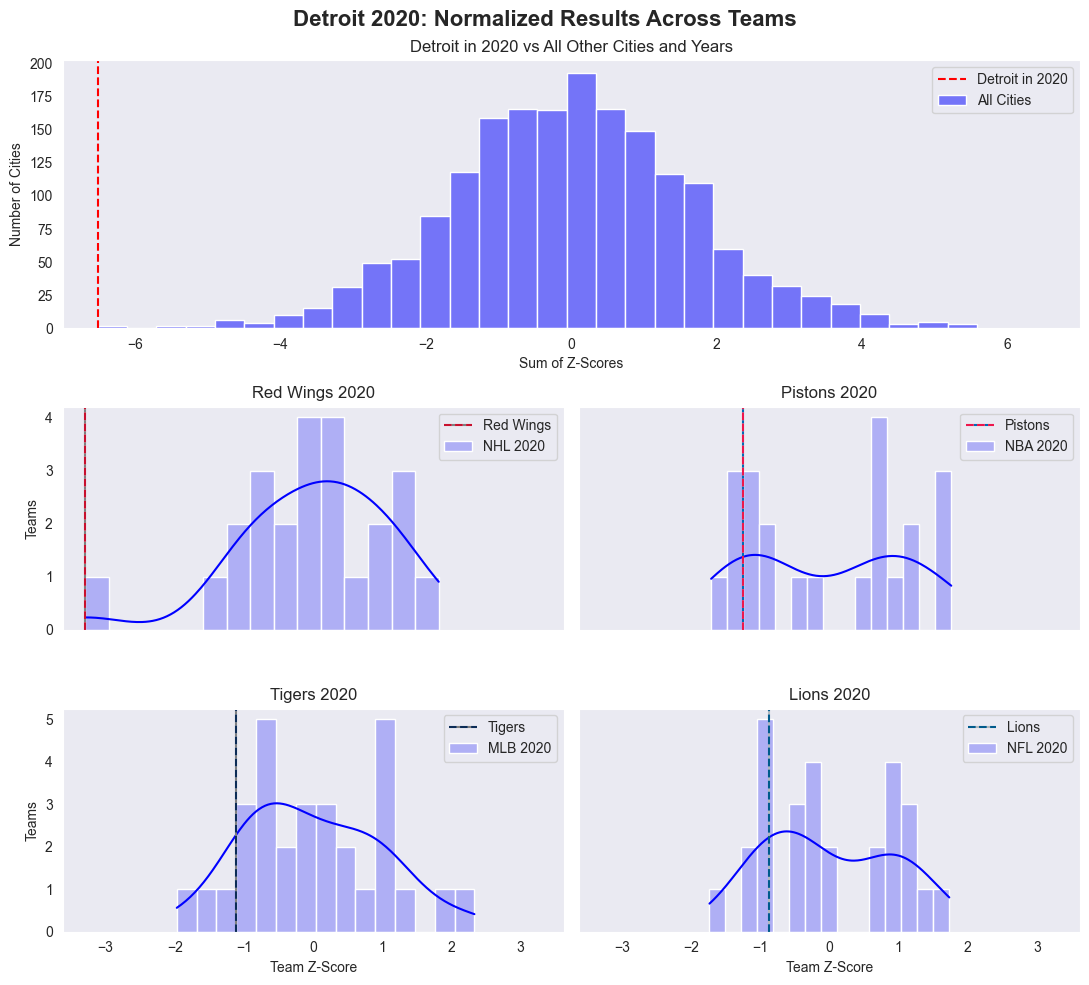

In [373]:
plot_city_year('Detroit', 2020)

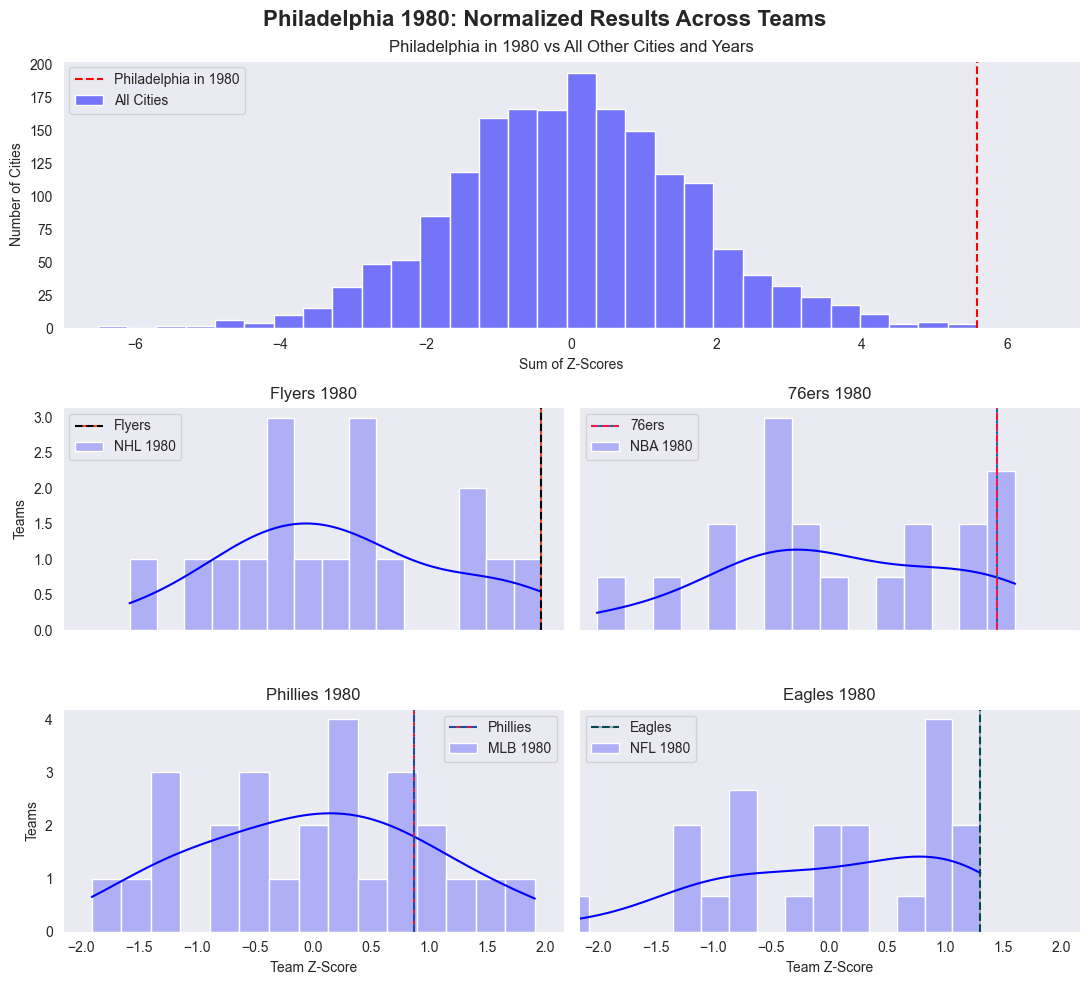

In [426]:
plot_city_year('Philadelphia', 1980)

Text(0.5, 1.0, 'Detroit, Chicago, and Everyone Else')

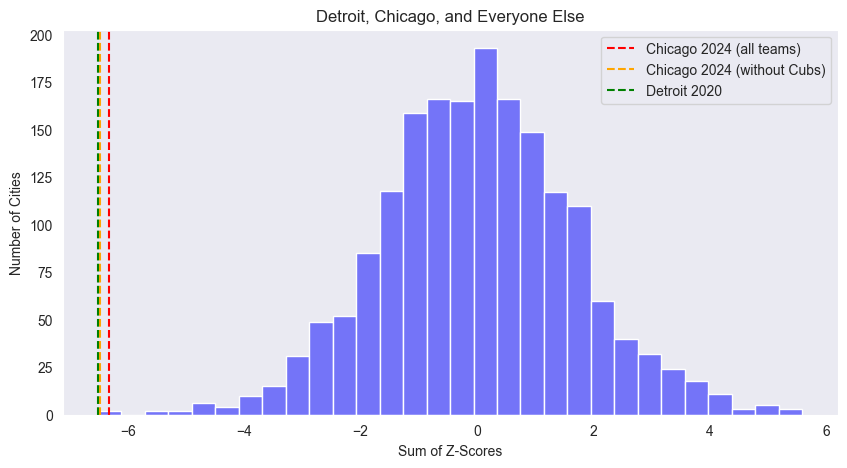

In [438]:
# All cities histogram with lines for Chicago 2024, Detroit 2020, and Chicago 2024 sans Cubs

plt.figure(figsize=(10, 5))

sns.set_style("dark")
sns.histplot(grouped_standings, x='sum', alpha=0.5, bins=30, color='blue')
plt.axvline(grouped_standings[
    (grouped_standings['city_group'] == 'Chicago') &
    (grouped_standings['season_year'] == 2024)
]['sum'].values[0], color='red', linestyle='--', label='Chicago 2024 (all teams)')
plt.axvline(
    standings[(standings['city'] == 'Chicago')
              & (standings['season_year'] == 2024)
                & (standings['name'] != 'Cubs')]['z_score'].sum(
    ), color='orange', linestyle='--', label='Chicago 2024 (without Cubs)')
plt.axvline(grouped_standings[
    (grouped_standings['city_group'] == 'Detroit') &
    (grouped_standings['season_year'] == 2020)
]['sum'].values[0], color='green', linestyle='--', label='Detroit 2020')
plt.legend()
plt.xlabel('Sum of Z-Scores')
plt.ylabel('Number of Cities')
plt.title('Detroit, Chicago, and Everyone Else')

In [473]:
grouped_standings[grouped_standings['count']>2].sort_values('mean')

,season_year,city_group,sum,mean,count
1643,2020,Detroit,-6.514104,-1.628526,4
57,1971,Buffalo,-4.553482,-1.517827,3
1262,2008,Seattle,-4.532191,-1.510730,3
1413,2013,Houston,-4.072720,-1.357573,3
1352,2011,Minnesota,-5.372812,-1.343203,4
...,...,...,...,...,...
613,1989,Bay Area,5.172179,1.293045,4
1569,2018,Boston,5.355384,1.338846,4
908,1998,Atlanta,4.186768,1.395589,3
344,1980,Philadelphia,5.584138,1.396035,4


In [471]:
def cities_with_lines(title, lines=[], agg_func=sum):
    print(agg_func.__name__)
    plt.figure(figsize=(10, 5))

    sns.set_style("dark")
    sns.histplot(
        grouped_standings[grouped_standings['count']>2]
        , x=agg_func.__name__, alpha=0.5, bins=30, color='blue')
    for line in lines:
        scores = standings[(standings['city_group'] == line['city']) &
            (standings['season_year'] == line['year'])]['z_score']
        
        value = agg_func(scores)
        plt.axvline(
            value,
            label=f"{line['city']} {line['year']}",
            color=line['color'],
            linestyle='--'
        )
    plt.legend()
    plt.xlabel(f'{agg_func.__name__.title()} of Z-Scores')
    plt.ylabel('Number of Cities')
    plt.title(title)


mean


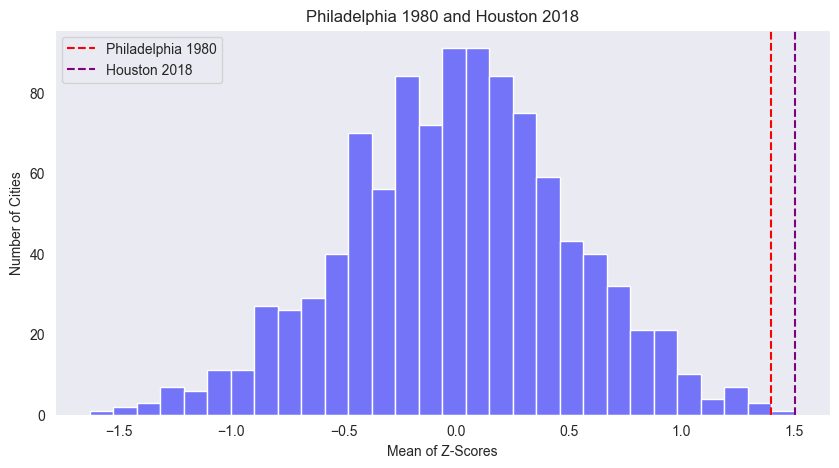

In [472]:
cities_with_lines(
    'Philadelphia 1980 and Houston 2018',
    lines=[
        {'city': 'Philadelphia', 'year': 1980, 'color': 'red'},
        {'city': 'Houston', 'year': 2018, 'color': 'purple'}
    ], agg_func=np.mean
)

In [413]:
def team_plot(team, league, year, comp='all'):
    if comp == 'all':
        df_hist = standings
    else:
        df_hist = standings[standings['league'] == league]
    
    main_color, gapcolor = get_colors(team, league)

    plt.figure(figsize=(10, 5))

    if comp != 'all':
        plt.title(f'{year} {team} vs {league} Teams Since 1969')
    else:
        plt.title(f'{year} {team} vs All Teams Since 1969')

    sns.histplot(df_hist, x='z_score', alpha=0.75, bins=40, color='blue', label= f'Other teams')
    plt.axvline(standings[
        (standings['name'] == team) &
        (standings['season_year'] == year) &
        (standings['league'] == league)
    ]['z_score'].values[0], color=main_color, gapcolor=gapcolor, linestyle='--', label=team)

    plt.xlabel('Z-Score')
    plt.ylabel('Number of Teams')
    plt.legend()



In [418]:
standings[(standings['city'] == 'Chicago')
              & (standings['season_year'] == 2024)
                & (standings['name'] != 'Cubs')]['z_score'].sum(
    )

-6.47296369488036

In [429]:
grouped_standings[grouped_standings['count']>2].sort_values('mean', ascending=True)

,season_year,city_group,sum,mean,count
1643,2020,Detroit,-6.514104,-1.628526,4
57,1971,Buffalo,-4.553482,-1.517827,3
1262,2008,Seattle,-4.532191,-1.510730,3
1413,2013,Houston,-4.072720,-1.357573,3
1352,2011,Minnesota,-5.372812,-1.343203,4
...,...,...,...,...,...
613,1989,Bay Area,5.172179,1.293045,4
1569,2018,Boston,5.355384,1.338846,4
908,1998,Atlanta,4.186768,1.395589,3
344,1980,Philadelphia,5.584138,1.396035,4


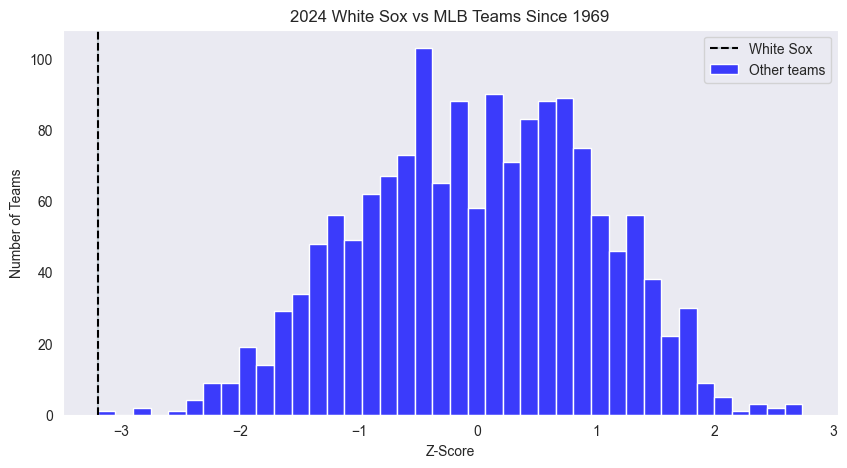

In [415]:
team_plot('White Sox', 'MLB', 2024, comp='MLB')

In [388]:
standings[(standings['name'] == 'Red Wings')
          & (standings['season_year'] == 2020)]

,city,name,percentage,season_year,season,league,city_group,season_order,chart_position,z_score,rolling_mean
5388,Detroit,Red Wings,0.274648,2020,20192020,NHL,Detroit,0.0,2020.0,-3.293094,-1.708998


In [391]:
standings[(standings['city_group'] == 'Chicago') 
          & (standings['season_year'] == 2024)]

,city,name,percentage,season_year,season,league,city_group,season_order,chart_position,z_score,rolling_mean
5873,Chicago,Blackhawks,0.317073,2024,20232024,NHL,Chicago,0.0,2024.00,-2.181253,-1.024720
5904,Chicago,Bulls,0.476000,2024,2023-24,NBA,Chicago,1.0,2024.25,-0.146744,-1.099508
5924,Chicago,White Sox,0.253086,2024,2024,MLB,Chicago,2.0,2024.50,-3.200810,-1.518693
5944,Chicago,Cubs,0.512346,2024,2024,MLB,Chicago,2.0,2024.50,0.159710,-1.342274
5960,Chicago,Bears,0.294118,2024,2024,NFL,Chicago,3.0,2024.75,-0.944157,-1.033000


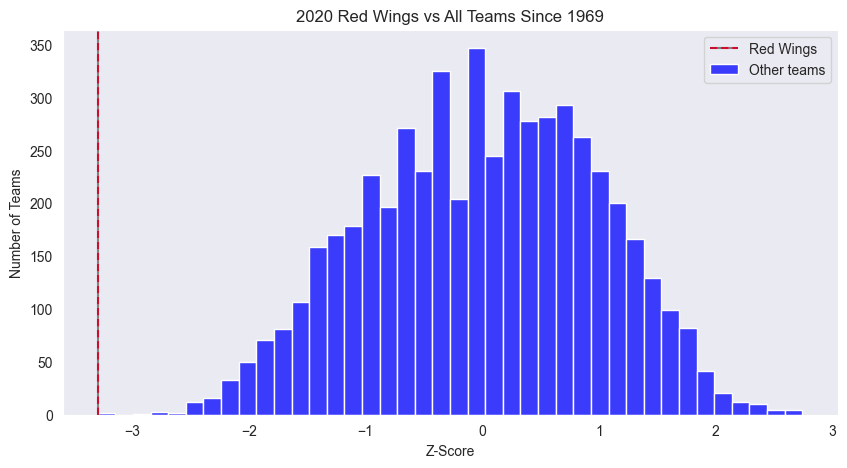

In [389]:
team_plot('Red Wings', 'NHL', 2020)

In [304]:
df_nfl_dist = standings[standings['league'] == 'NFL']
df_mlb_dist = standings[standings['league'] == 'MLB']
df_nhl_dist = standings[standings['league'] == 'NHL']
df_nba_dist = standings[standings['league'] == 'NBA']

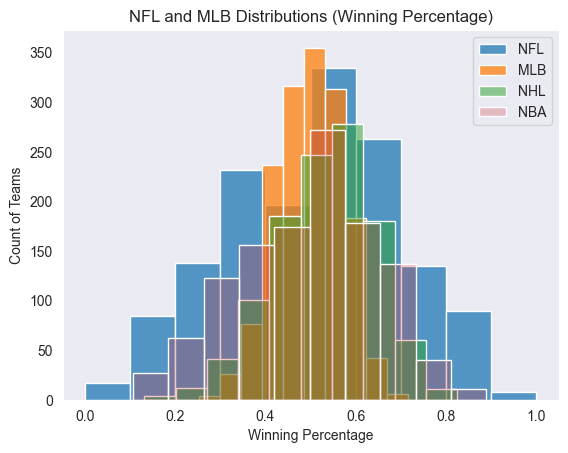

In [307]:
sns.histplot(df_nfl_dist, x = 'percentage', bins=10)
sns.histplot(df_mlb_dist, x = 'percentage', bins=10, alpha=0.75)
sns.histplot(df_nhl_dist, x = 'percentage', bins=10, alpha=0.5)
sns.histplot(df_nba_dist, x = 'percentage', bins=10, alpha=0.25)
plt.title('NFL and MLB Distributions (Winning Percentage)')
plt.xlabel('Winning Percentage')
plt.ylabel('Count of Teams')
plt.legend(['NFL', 'MLB', 'NHL', 'NBA'])


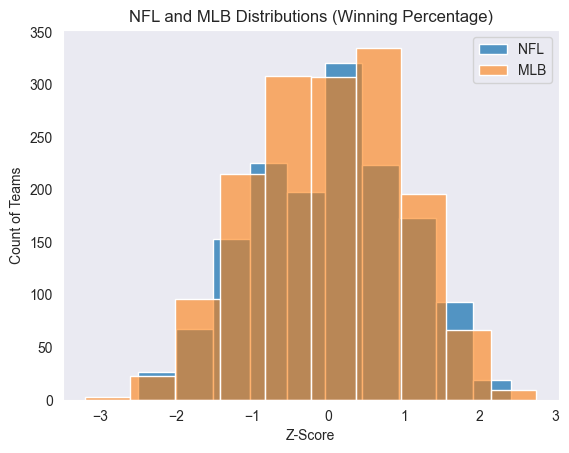

In [308]:
sns.histplot(df_nfl_dist, x = 'z_score', bins=10)
sns.histplot(df_mlb_dist, x = 'z_score', bins=10, alpha=0.6)
plt.title('NFL and MLB Distributions (Winning Percentage)')
plt.xlabel('Z-Score')
plt.ylabel('Count of Teams')
plt.legend(['NFL', 'MLB'])

In [497]:
standings[(standings['league'] == 'NFL') & (standings['season_year'] == 2024)].drop_duplicates(subset=['z_score'])

,city,name,percentage,season_year,season,league,city_group,season_order,chart_position,z_score,rolling_mean
5951,Tampa Bay,Buccaneers,0.588235,2024,2024,NFL,Tampa Bay,3.0,2024.75,0.404639,0.233334
5953,Minnesota,Vikings,0.823529,2024,2024,NFL,Minnesota,3.0,2024.75,1.483675,0.621403
5954,Washington,Commanders,0.705882,2024,2024,NFL,Washington,3.0,2024.75,0.944157,-0.441100
5956,New Orleans,Saints,0.294118,2024,2024,NFL,New Orleans,3.0,2024.75,-0.944157,-0.016146
5957,Arizona,Cardinals,0.470588,2024,2024,NFL,Phoenix,3.0,2024.75,-0.134880,0.085101
5958,Dallas,Cowboys,0.411765,2024,2024,NFL,Dallas,3.0,2024.75,-0.404639,0.326287
5959,San Francisco,49ers,0.352941,2024,2024,NFL,Bay Area,3.0,2024.75,-0.674398,-0.335553
5964,Kansas City,Chiefs,0.882353,2024,2024,NFL,Kansas City,3.0,2024.75,1.753434,0.289509
5966,Cleveland,Browns,0.176471,2024,2024,NFL,Cleveland,3.0,2024.75,-1.483675,0.217882
5968,New England,Patriots,0.235294,2024,2024,NFL,Boston,3.0,2024.75,-1.213916,0.387134


<Axes: xlabel='season_year', ylabel='percentage'>

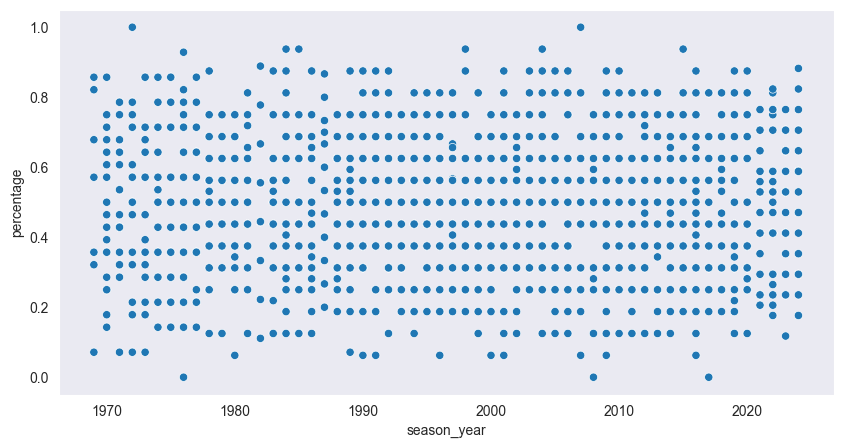

In [508]:
plt.figure(figsize=(10, 5))
sns.scatterplot(standings[standings['league'] == 'NFL'], x='season_year', y='percentage', hue='league', legend=False)

<Axes: xlabel='season_year', ylabel='mean'>

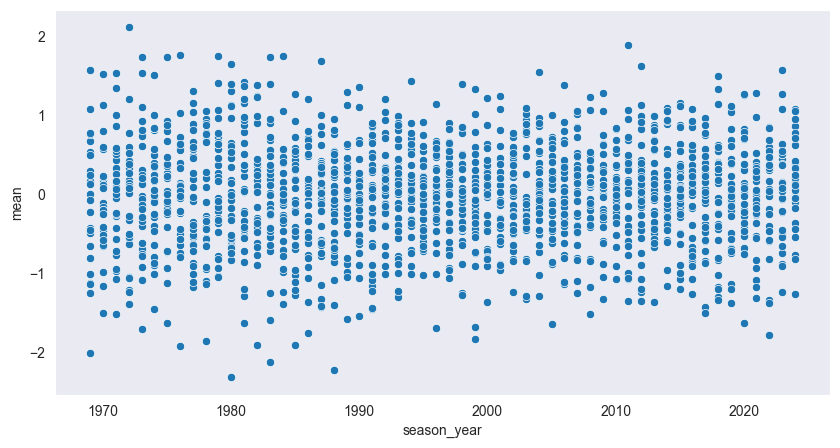

In [482]:
plt.figure(figsize=(10, 5))
sns.scatterplot(grouped_standings, x='season_year', y='mean')